# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [9]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

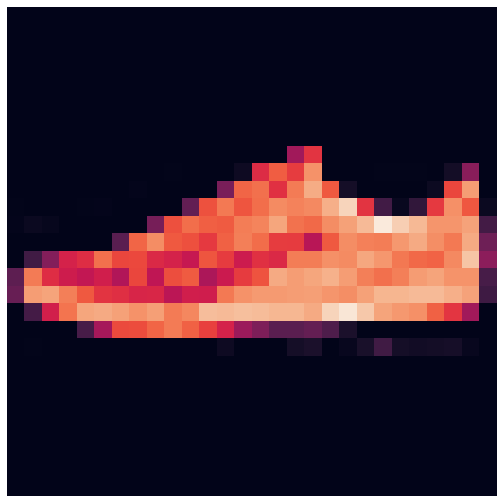

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

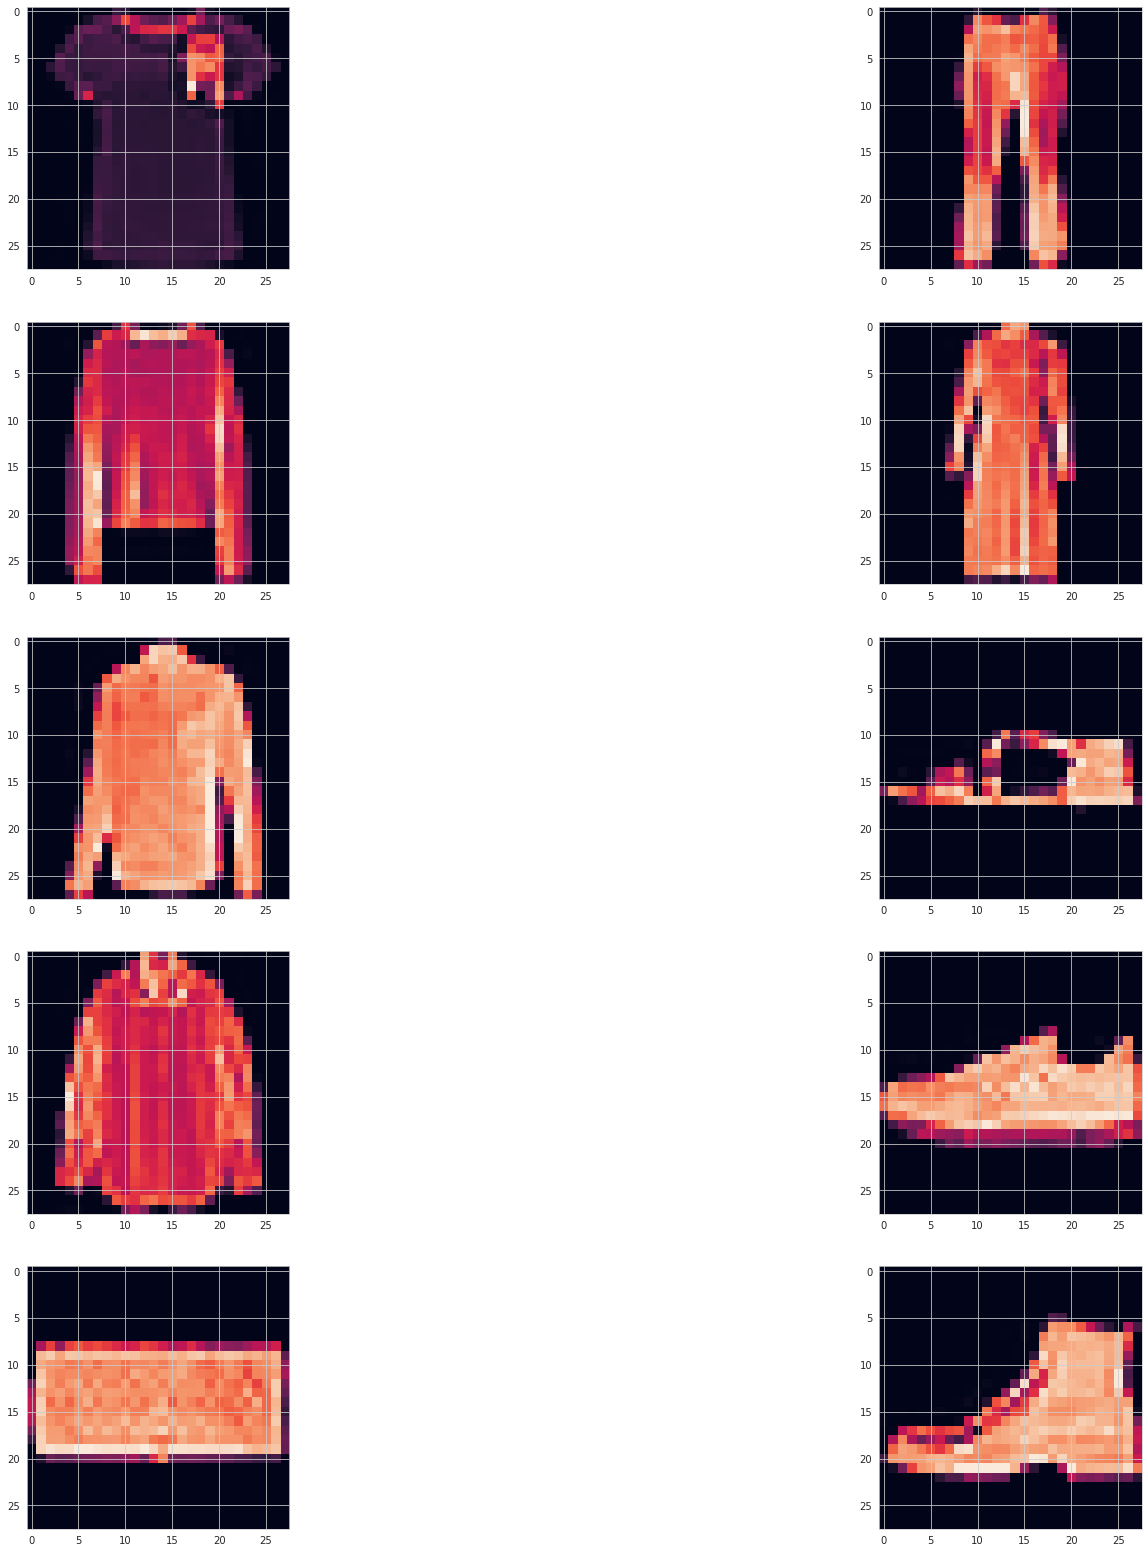

In [6]:
plt.figure(figsize =(28, 28)) 


#Find first indices of classes

def first_idx(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    return None

#Now lets plot unique classes of pictures:

for i in range(0,10):
    idx = first_idx(y, str(i))[0]
    #print(idx)
    plt.subplot(5, 2,i+1)    # the number of images in the grid is 5*2 (25)
    plt.imshow(X[int(idx)].reshape(28, 28, 1))

plt.show()

    


### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [7]:
#Estimate volume of classes:

def all_idx(arr, idx):
    #idx should be str
    return np.where(arr == idx)


def estimate_volume(arr, target):
    class_V = pd.DataFrame(columns = ['Class', 'Volume'])
    for i in range(0, 10):
        i = str(i)
        class_idxs = all_idx(target, i)
        cur_class = arr.take(class_idxs, axis = 0)
        class_V = class_V.append({'Class': f'Class_{i}', 'Volume' : f'{cur_class.size}'}, ignore_index = True)
    return class_V

estimate_volume(X, y)

#Here we see that some classes have more images than others - it tells about inbalanced state of the former.

,Class,Volume
0,Class_0,72912
1,Class_1,79968
2,Class_2,74480
3,Class_3,94864
4,Class_4,75264
5,Class_5,76832
6,Class_6,79184
7,Class_7,61936
8,Class_8,85456
9,Class_9,83104


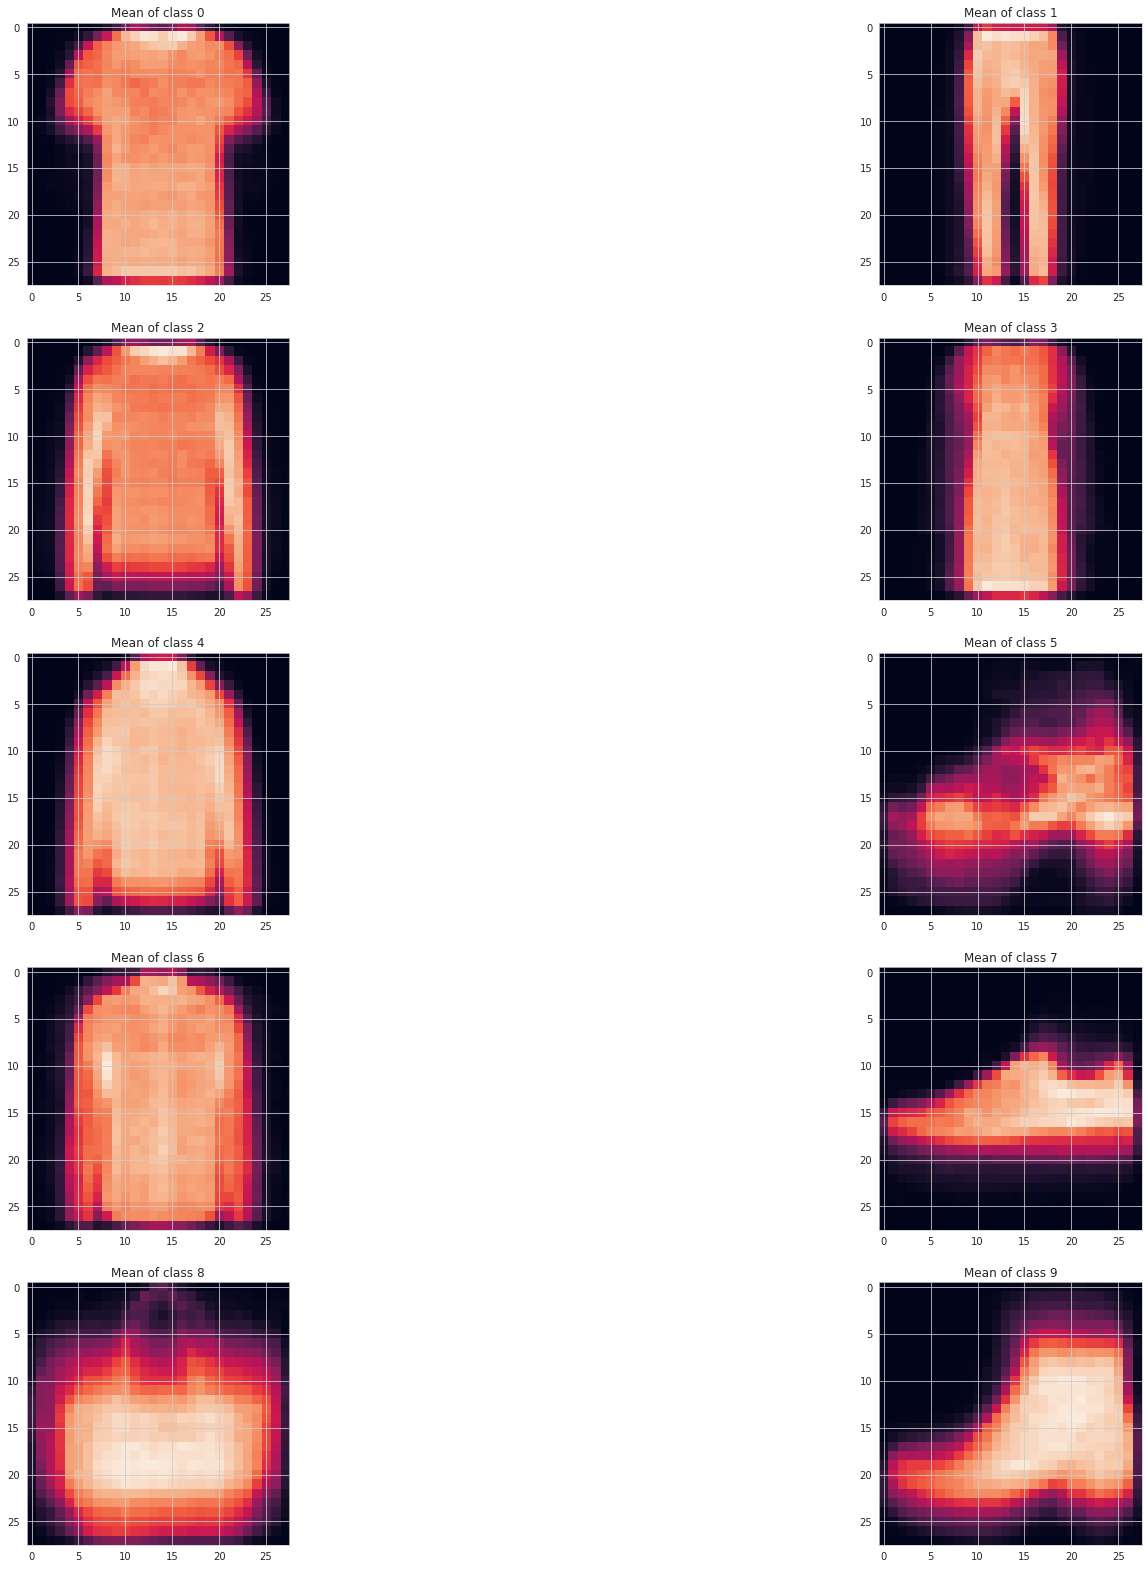

In [8]:
#Estimate mean of pictures by classes:

plt.figure(figsize =(28, 28)) 

def all_idx(arr, idx):
    #idx should be str
    return np.where(arr == idx)

def estimate_mean(arr, target):
    for i in range(0, 10):
        i = str(i)
        class_idxs = all_idx(target, i)
        cur_class = arr.take(class_idxs, axis = 0)
        mean_img = np.mean(cur_class, axis = 1)
        plt.subplot(5, 2, int(i) + 1).set_title(f'Mean of class {i}')    # the number of images in the grid is 5*2 (25)
        plt.imshow(mean_img.reshape(28, 28, 1))
        #print(class_idxs)

    plt.show()
    
estimate_mean(X, y)



#We see that in averga our classes have pretty the same mean of pictures' resolution.\
#However, classes 3, 5, 8, 9 and, probably, 7 show worse quality. 

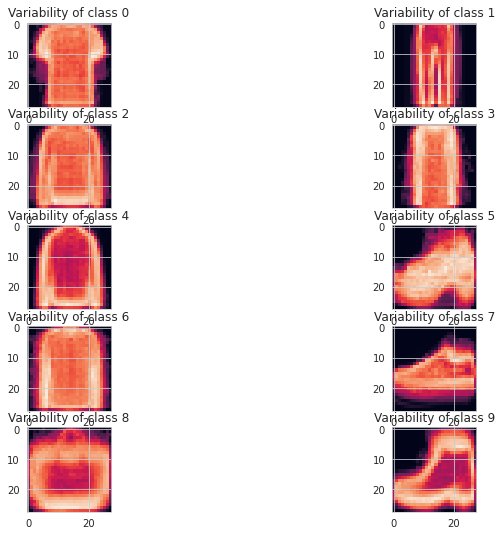

In [9]:
#See variablity of each class

def all_idx(arr, idx):
    #idx should be str
    return np.where(arr == idx)


def estimate_std(arr, target):
    for i in range(0, 10):
        i = str(i)
        class_idxs = all_idx(target, i)
        cur_class = arr.take(class_idxs, axis = 0)
        mean_img = np.std(cur_class, axis = 1)
        plt.subplot(5, 2, int(i) + 1).set_title(f'Variability of class {i}')    # the number of images in the grid is 5*2 (25)
        plt.imshow(mean_img.reshape(28, 28, 1))
        #print(class_idxs)

    plt.show()
    
estimate_std(X, y)

#Here we can notice that classes 2, 5, 6 and 8 posses more exact variablity

##SUMMARY:
#According to means and stds results we can admitt that our classes are slighlty balanced. \
#Hence, the learning of NN to identify class would be difficult because of the "smearing" of the dataset.

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [10]:
#Divide array on test and train sets. \
#It's considered that random number of simulations equal to 42 would give the most repetitive result (most obvious) \
#The proportion of train to test sets depend on the aim and design, however usually 80 to 20 is used.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=111)
X_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 76.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [11]:
def get_class(arr, target, k):
    idxs_0 = np.where(target == str(k[0]))
    idxs_1 = np.where(target == str(k[1]))
    idxs = np.sort(np.append(idxs_0, idxs_1))
    arr = arr.take(idxs, axis = 0)
    return arr, target[idxs]

X_01_train, y_01_train = get_class(X_train, y_train, [0,1])

X_01_test, y_01_test = get_class(X_test, y_test, [0,1])
#get_class(X_train, y_train, [0,1])
#X_1 = get_class(X, y, 1)
y_01_test

array(['1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '1',
       '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1',
       '0', '1', '0', '0', '1', '0', '1', '1', '1', '0'], dtype=object)

In [12]:
#DRAFT
dist_mtrx = np.zeros((X_01_test.shape[0], X_01_train.shape[0]))

for j in range(X_01_train.shape[0] - 1):
    for i in range(X_01_test.shape[0] - 1):
        dist_elem = X_01_train[j] - X_01_test[i]
        module = abs(dist_elem)
        #print(sum(module))
        dist_mtrx[i,j] = sum(module)
        
   
dist_mtrx

array([[32969., 31290., 19203., ..., 62868., 37755.,     0.],
       [67715., 66710., 62803., ..., 24482., 58947.,     0.],
       [26156., 26141., 18322., ..., 62289., 33226.,     0.],
       ...,
       [20831., 12290., 40173., ..., 63980., 42463.,     0.],
       [18078., 14331., 33886., ..., 60359., 41702.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [13]:
#DRAFT
dist_mtrx2 = np.zeros((X_01_test.shape[0], X_01_train.shape[0]))
for i in range(0,X_01_test.shape[0] - 1):
    dist_mtrx2[i, :] = np.sum(np.abs(np.subtract(X_01_test[i],X_01_train)), axis = 1) #using broadcasting
    #subtract - alternative to 'difference';
    #abs - module;
    #sum - need to set axis = 1 (otherwise will sum by rows)
    # np used as otherwise will not be able to apply broadcasting
dist_mtrx2

array([[32969., 31290., 19203., ..., 62868., 37755., 19107.],
       [67715., 66710., 62803., ..., 24482., 58947., 74821.],
       [26156., 26141., 18322., ..., 62289., 33226., 15722.],
       ...,
       [20831., 12290., 40173., ..., 63980., 42463., 36273.],
       [18078., 14331., 33886., ..., 60359., 41702., 31338.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [14]:
#DRAFT
#To generate pairwise distance estimation only by one line we have to solve dimension problem \
#The basic option - add one more special exis to one of the set\
#Extra dimension will provide an opportunity to re-scale resulting matrix ~ broadcasting
#axis = -1 set by which axis we ought to sum values (herein - the 3d one, set as -1)

dist_mtrx3 = np.sum(np.abs(X_01_train - X_01_test[:, None]), axis = -1)

dist_mtrx3.shape

(36, 159)

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [15]:
from knn import KNNClassifier
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_01_train, y_01_train)
print(knn_classifier)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [16]:
# TODO: compute_distances_two_loops - DRAFT
dists = knn_classifier.compute_distances_two_loops(X_01_test)
#print(dists)
assert np.isclose(dists[0, 100], np.sum(np.abs(X_01_test[0] - X_01_train[100])))

In [17]:
# TODO: compute_distances_one_loop - DRAFT
dists = knn_classifier.compute_distances_one_loop(X_01_test)
assert np.isclose(dists[0, 100], np.sum(np.abs(X_01_test[0] - X_01_train[100])))

In [18]:
# TODO: compute_distances_no_loops - DRAFT
dists = knn_classifier.compute_distances_no_loops(X_01_test)
assert np.isclose(dists[0, 100], np.sum(np.abs(X_01_test[0] - X_01_train[100])))

Проверим скорость работы реализованных методов

In [19]:
%timeit knn_classifier.compute_distances_two_loops(X_01_test)
%timeit knn_classifier.compute_distances_one_loop(X_01_test)
%timeit knn_classifier.compute_distances_no_loops(X_01_test)

265 ms ± 3.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.95 ms ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.1 ms ± 814 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Реализуем метод для предсказания меток класса

In [20]:
#For prediction function - DRAFT

n_train = dists.shape[1]
n_test = dists.shape[0]
predictions = np.empty(n_test, dtype = int)
classes = []
#indic = []
k = 10
#iterate over testing samples
for i in range(n_test):
    #get distances for the i-sample
    test_D = dists[i,:]
    #sort distances
    sorted_D = list(sorted(test_D, key = lambda x: x)) #lambda tells to sort by the 1st arg in array - dist 
    #if k is set - take first k elements from sorted distances
    if k is not None:
        kD_sort = sorted_D[:k]
        #iter over first min distances
        for min_D in range(len(kD_sort)):
            #get indicies of dist from default set equal to the min one
            idx = list(test_D).index(kD_sort[min_D])
            #extract min class from train set and append to list
            class_min = y_01_train.astype(int)[idx]
            classes.append(class_min)
            #try found the only most frequent class
            try:
                sample_class = max(classes, key = classes.count)
            #if more than one frequent - get min
            except ValueError:
                sample_class = class_min
        predictions[i] = sample_class
    else:
        for min_D in range(len(sorted_D)):
            idx = list(test_D).index(sorted_D[min_D])
            class_min = y_01_train.astype(int)[idx]
            classes.append(class_min)
            try:
                sample_class = max(classes, key = classes.count)
            except ValueError:
                sample_class = class_min
        predictions[i] = sample_class


predictions


array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(X_01_test)

prediction == y_01_test.astype(int)

array([ True, False,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True, False,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True, False,
        True, False, False,  True, False,  True,  True,  True, False])

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [22]:
# TODO: binary_classification_metrics in metrics.py

def binary_classification_metrics(prediction, test_y):
    n_sample = prediction.shape[0]
    TP, FP = 0, 0
    TN, FN = 0, 0
    test = test_y.astype(int)
    for i in range(n_sample):
        if test[i] == 1 and prediction[i] == 1:
            TP += 1
        elif test[i] == 0 and prediction[i] == 1:
            FP += 1
        elif test[i] == 0 and prediction[i] == 0:
            TN += 1
        elif test[i] == 1 and prediction[i] == 0:
            FN += 1
    try:
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        accuracy = (TP + TN)/(TP + TN + FP + FN)
        f_m = 2*(precision*recall/(precision + recall))
    except ZeroDivisionError:
        print("Could not divide by zero. Precision and F1 score can't be counted")
        recall = TP/(TP+FN)
        accuracy = (TP + TN)/(TP + TN + FP + FN)
        precision, f_m = None, None
        
    
    return precision, recall, accuracy, f_m

binary_classification_metrics(prediction, y_01_test)

(0.6333333333333333,
 0.9047619047619048,
 0.6388888888888888,
 0.7450980392156863)

In [23]:
binary_classification_metrics(prediction, y_01_test)[1]

0.9047619047619048

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy_score(prediction, y_01_test.astype(int))


0.6388888888888888

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [25]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    m = metric
    m_tst, m_tr = [], []
    k_arr = params
    for k_i in k_arr:
        knn_classifier = KNNClassifier(k=k_i)
        knn_classifier.fit(X_train, y_train)
        
        distances = knn_classifier.compute_distances_one_loop(X_test) 
        prediction = knn_classifier.predict(X_test)
        if m == 'accuracy_score':
            tst = binary_classification_metrics(prediction, y_test)[2]
            tr = binary_classification_metrics(prediction, y_train)[2]
            m_tr.append(tr)
            m_tst.append(tst)
            
        elif m == 'precision':
            tst = binary_classification_metrics(prediction, y_test)[0]
            tr = binary_classification_metrics(prediction, y_train)[0]
            m_tr.append(tr)
            m_tst.append(tst)
           
        elif m == 'recall':
            tst = binary_classification_metrics(prediction, y_test)[1]
            tr = binary_classification_metrics(prediction, y_train)[1]
            m_tr.append(tr)
            m_tst.append(tst)
            
        elif m == 'f1_score':
            tst = binary_classification_metrics(prediction, y_test)[3]
            tr = binary_classification_metrics(prediction, y_train)[3]
            m_tr.append(tr)
            m_tst.append(tst)
            
        
        print(f'For k = {k_i}' + f' test and train {metric} are {tst} and {tr}')
    
    return m_tr, m_tst
    

In [26]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_01_train, y_01_train, X_01_test, y_01_test, [1, 2, 4, 5, 8, 10, 30], 'accuracy_score')

For k = 1 test and train accuracy_score are 0.6388888888888888 and 0.4722222222222222
For k = 2 test and train accuracy_score are 0.6388888888888888 and 0.4722222222222222
For k = 4 test and train accuracy_score are 0.6666666666666666 and 0.4444444444444444
For k = 5 test and train accuracy_score are 0.6666666666666666 and 0.4444444444444444
For k = 8 test and train accuracy_score are 0.6388888888888888 and 0.4722222222222222
For k = 10 test and train accuracy_score are 0.6666666666666666 and 0.4444444444444444
For k = 30 test and train accuracy_score are 0.6388888888888888 and 0.4722222222222222


In [27]:
#len(X_01_train)
#accuracy_score(prediction, )

TypeError: accuracy_score() missing 1 required positional argument: 'y_pred'

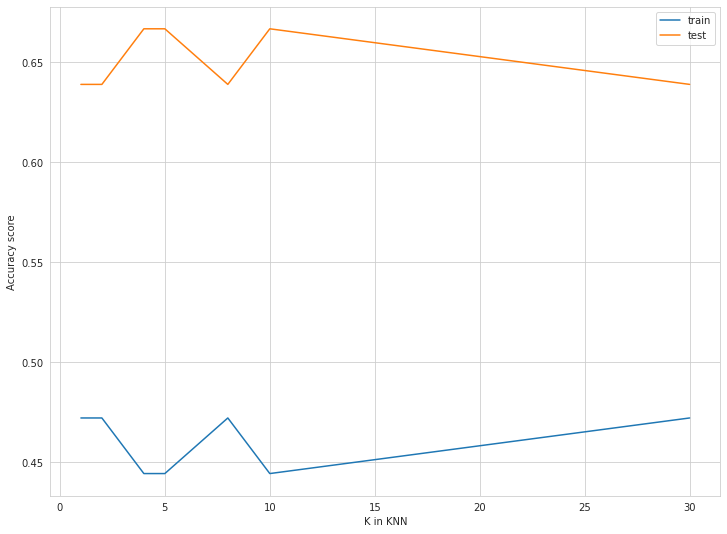

In [28]:

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [29]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 9, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3])

In [ ]:
predictions == y_test.astype(int)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [ ]:
# TODO: multiclass_accuracy in metrics.py
#multiclass_accuracy(predictions, y_test)
def multiclass_accuracy(prediction, y_test, adj = False):
    n_sample = prediction.shape[0]
    total_accuracy = np.sum(prediction == y_test.astype(int))/n_sample
    if adj:
        adj_acc = sum(abs(prediction - y_test.astype(int)) <= 1)/n_sample
        return adj_acc
    return total_accuracy

multiclass_accuracy(predictions, y_test, adj = True)

In [ ]:

np.unique(y_test)

In [30]:
def find_best_k_mutli(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    m_tr = []
    m_tst = []
    k_arr = params
    for k_i in k_arr:
        knn_classifier = KNNClassifier(k=k_i)
        knn_classifier.fit(X_train, y_train)
        
        distances = knn_classifier.compute_distances_one_loop(X_test) 
        prediction = knn_classifier.predict(X_test)
        if accuracy_score:
            tst = multiclass_accuracy(prediction[:k_i], y_test[:k_i])
            tr = multiclass_accuracy(prediction[:k_i], y_train[:k_i])
            m_tst.append(tst)
            m_tr.append(tr)
            print(f'For k = {k_i}' + f' test and train accuracy are {tst} and {tr}')
        else:
            return 'Metric is not defined'
    return m_tr, m_tst 
    

In [31]:
train_metrics, test_metrics = find_best_k_mutli(X_train, y_train, X_test, y_test, [1, 2, 4, 5, 8, 10, 30], accuracy_score)


For k = 1 test and train accuracy are 1.0 and 0.0
For k = 2 test and train accuracy are 0.5 and 0.0
For k = 4 test and train accuracy are 0.25 and 0.0
For k = 5 test and train accuracy are 0.2 and 0.0
For k = 8 test and train accuracy are 0.25 and 0.125
For k = 10 test and train accuracy are 0.2 and 0.1
For k = 30 test and train accuracy are 0.26666666666666666 and 0.16666666666666666


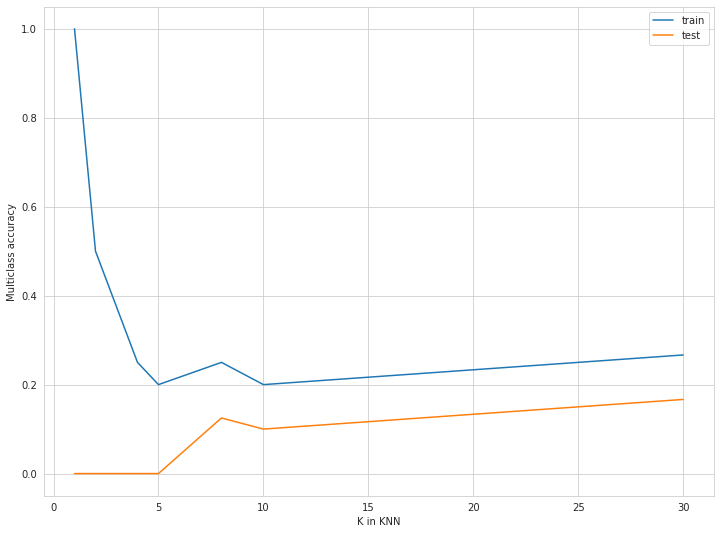

In [32]:
tr_metrics, tst_metrics = test_metrics, train_metrics

plt.plot([1, 2, 4, 5, 8, 10, 30], tr_metrics, label="train")
plt.plot([1, 2, 4, 5, 8, 10, 30], tst_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Multiclass accuracy");

In [ ]:
train_metrics, test_metrics

Как видно на графиках при k от 8 до 15 в случае мультиклассовой классификации у нас точность предсказания для тестового и тринировочного сета сходится. Мы видим, что с каждым следующим соседом точность предсказания алгоритма на тренировочном сете остается почти неизменной. При k = 1, на тренировочных данных наша модель предсказывает с максимальной точностью (но при этом её тестовый запуск говорит о том, что модель не способна классифицировать на реальных данных). 

Если модель для предсказания оценивает первые 10 соседей, то уже точность классификации как на тренировочных данных, так и на тестовых начинает примерно совпадать. Это говорит о значимой специфичность и растущей чувствительности алгоритма. 

Любопытно, что с дальнейшим взятием следующих соседей точность в случае тестовых и тренировочных данных приобретает линейных характер роста - это может быть ввиду того, что модель "привыкает" к структуре данных и "размазывает" свое предсказание, становясь менее чувствительной к случаным отклонениям от общей структуры сета.

Тем не менее, такая зависимость может быть ошибочна, так как есть вероятность, что анализированное количество соседей недостаточно для оценки точности алгоритма при равномерности тестовых данных по наполненности классами (что при одинаковой их встречамости, но разной структуре, точность будет аналогична).  

Таким образом, мы видим, что лучшая точность алгоритма наблюдается при k ~ 8. То есть для определения класса картинки модели необъодимо оценить отклонение точки от ближайших 8 соседей.

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

Если посмотреть на описание ['данных'](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset), то можно увидеть, что к параметрам уже была применена стандартизация по среднему и std. Причина, по которой здесь неободимо стандартизировать значения - разный "формат" данных. В случае линейной регрессии обычно применяют нормальную или экспоненциальную стандартизации, что позволяет далее строить модели по "усредненным" единицам измерения. Без стандартизации здесь бы возникал конфликат между, например, возрастом и уровнем ЛПНП. Однако стандартизация "подвела все единицы под одну гребенку", что теперь позволит построить валидную модель предсказания. Особенно в случае метода регрессии, который очень чувствителен к выбросам (обычная регрессионна модель не учитывает их при посторении, так как будет конструироваться по наиболее представленным параметрам). 

In [10]:
#Соберем тестовый и тренировочный наборы данных
X_arr, y_arr = np.array(X), np.array(y)

X_arr_tr, X_arr_tst, y_arr_tr, y_arr_tst = train_test_split(X_arr, y_arr, test_size = 0.20, random_state = 111)

Сделаем анализ EDA (объем, среднее и std)

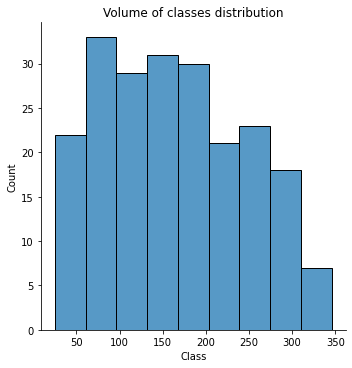

In [11]:
#Volume
def all_idx(arr, idx):
    return np.where(arr == idx)


def volume_diabetes(arr, target):
    class_V = pd.DataFrame(columns = ['Class', 'Volume'])
    for i, idx in enumerate(np.unique(target)):
        class_idxs = all_idx(target, idx)
        cur_class = arr.take(class_idxs, axis = 0)
        class_V = class_V.append({'Class': int(idx), 'Volume' : cur_class.size}, ignore_index = True)
    return class_V


diab_V = volume_diabetes(X_arr, y_arr)
sns.displot(diab_V, x = 'Class').set(title = 'Volume of classes distribution')

Как можно заметить, что больше всего у нас присутсвует показателей, которые изменились на 50-100 количественных единиц за год с начала болезни. И меньше всего наиболее критичных показателей, которые бы прогрессировали на почти 350 единиц.

In [ ]:
#Mean and plot it

def mean_diab(arr, target):
    class_M = pd.DataFrame(columns = ['Changed by', 'M'])
    for i, idx in enumerate(np.unique(target)):
        #i = str(i)
        class_idxs = all_idx(target, idx)
        cur_class = arr.take(class_idxs, axis = 0)
        mean_cl = np.mean(cur_class, axis = 1).sum()/len(np.mean(cur_class, axis = 1))
        class_M = class_M.append({'Changed by': int(idx), 'M' : mean_cl }, ignore_index = True)
    return class_M
diab_M = mean_diab(X_arr, y_arr)
sns.displot(diab_M, x = 'Changed by', y ='M', kind = 'kde').set(title = 'Average mean distribution per each class')
sns.displot(diab_M, x = 'M').set(title = 'Average mean distribution')

Здесь мы видим, что классы с изменением параметров на 100 и 200-300 (250) единиц имеют средние показатели равные -0.2-0.0 и ~0.2, соответственно. Если рассмотреть в целом распределение средних по классам, мы видим, что датасет не сбалансирован. Об этом также говорит и количественное распределение средних по их встречаемости, где наиболее частыми являются выше указанные.

In [ ]:
#Std

def mean_std(arr, target):
    class_std = pd.DataFrame(columns = ['Changed by', 'Std'])
    for i, idx in enumerate(np.unique(target)):
        #i = str(i)
        class_idxs = all_idx(target, idx)
        cur_class = arr.take(class_idxs, axis = 0)
        mean_std = np.std(cur_class, axis = 1).sum()/len(np.mean(cur_class, axis = 1))
        class_std = class_std.append({'Changed by': int(idx), 'Std' : mean_std}, ignore_index = True)
    return class_std
diab_std = mean_std(X_arr, y_arr)
sns.displot(diab_std, x = 'Changed by', y = 'Std', kind = 'kde').set(title = 'Average standard deviation distribution per each class')
sns.displot(diab_std, x = 'Std').set(title = 'Average standard deviation distribution' )
diab_std[(pd.to_numeric(diab_std['Std']) > 0.0) | (pd.to_numeric(diab_std['Std']) < 0.0) ]

Здесь мы можем заметить, что дисперсия параметров по классам на столь выраительна. Большая часть данных распределена равномерно, однако есть классы с явными колебаниями показателей (у которых показатели прогрессировани на 100 и 200 единиц). 


Таким образом, наши данные снова нельзя назвать идеально сбалансированными.

In [37]:
#Запустим обучение модели для предсказания абсолютной величины прогресса заболевания спустя год 
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_arr_tr, y_arr_tr)
pred_diab = knn_classifier.predict(X_arr_tst)

In [ ]:
y_arr_tst.astype(int) == pred_diab


#We see, that our model is too weak to predict with high accuracy. However still lets measure the metrics

In [38]:

multiclass_accuracy(pred_diab, y_arr_tst, adj = True)


0.033707865168539325

Мы видим, что наша модель предсказыват лишь с точностью 3% (adjacent acc, чтобы не потерять значимые выбросы при такое вариабельной выборке). Следовательно, kNN метод не подходит для поставленной задачи. Одна из возможных причин - тип target сета. В первом задании у нас классификация шла по категориальной переменной, в то время как здесь мы оперируем классификация на основе непрерывных данных. В случае, когда мы применяем метод дистанций к набору данных, которые группируется на основе непрерывной переменной, то получаемые дистанции будут крайне чувствительны отклонениям и variance категорий, так как даже в случае dummy конвертации наши бы "группы" имели перекрвающийся характер. И тогда бы средние расстояния и классификация на их основе не имела бы высокой точности и специфичности, так как в одну такую группу, на самом деле, входили бы показатели с разными std. 


Для решения проблеммы классификации непрерывных данных одним из способов будет выступать регрессия, которая отдельно будет учитывать отклонения для каждого измерения и каждого класса. Такой подход позволит избежать эффекта "облаков измерений" и спроектировать модель для учета каждой точки нашего распределения.


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
#As there is no need to standartize and scalar - StandardScaler will be omitted, however best k-neighbors will be determined/
pipe = Pipeline([
('select', SelectKBest(k=10)),
('selector', VarianceThreshold()),
('classifier', KNeighborsRegressor())
])
pipe.fit(X_arr_tr, y_arr_tr)
print('Training kNN score ' + f'{pipe.score(X_arr_tr, y_arr_tr)}' + '\n'
     'Test kNN score ' + f'{pipe.score(X_arr_tst, y_arr_tst)}')


### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [40]:
#Create a model using Pipeline

#As there is no need to standartize and scalar - StandardScaler will be omitted, however best k-neighbors will be determined/

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=111)



In [ ]:
pipe = Pipeline([
('select', SelectKBest(k=10)),
('selector', VarianceThreshold()),
('classifier', KNeighborsRegressor())
])
pipe.fit(X_train, y_train)
print('Training kNN score ' + f'{pipe.score(X_train, y_train)}' + '\n' +
'Test kNN score ' + f'{pipe.score(X_test, y_test)}')

Если оценивать в регрессионной модели ближайших 8 соседей, то мы видим, что её качество достаточно низкое - построенная модель способна предсказать лишь 35% от наблюдений для рандомного датасета. При этом точность и качество недостаточно значимое даже при воспроизведении модели на тренировочном датасете.

Для поиска более подходящего k воспользуемся специальной функцией подбора параметром - GridSearchCV. Предварительно написав интересующие нас параметры.

In [ ]:
#Set parametres for pipe
parameters = {
'classifier__n_neighbors': [1, 3, 5, 7, 10, 15, 20, 30, 50],
'classifier__p': [1, 2]
}

grid_diab = GridSearchCV(pipe, parameters, cv=2).fit(X_arr_tr, y_arr_tr)
best_param = grid_diab.best_params_

In [ ]:
print('Training set score: ' + str(grid_diab.score(X_arr_tr, y_arr_tr)))
print('Test set score: ' + str(grid_diab.score(X_arr_tst, y_arr_tst)))
print('Best k: ' + str(list(best_param.values())[0]))

Мы видим, что качество построенной модели повышается, если провести подбор оптимального k. Согласно анализу, среди 50 соседей наилучшую мощность модель показывает при предсказании переменных на 10 ближайших соседях. Однако если оценивать качество в среднем, то все еще регрессионная модель не показывает хорошие результаты качества предсказаний на тестовых и тренировочных данных. Однако теперь её точность стала ближе к тренировочном, что позволяет сделать вывод о приемлемой работе предиктора.

In [41]:
knnReg = KNeighborsRegressor(n_neighbors=10)

diab_reg = knnReg.fit(X_arr_tr, y_arr_tr)

predict_Di = diab_reg.predict(X_arr_tst) 


### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [49]:
# TODO: r_squared, mse, mae in metrics.py - DRAFT
r_sq_up, r_sq_down, mse, mae = 0, 0, 0, 0
for i in range(len(predict_Di)):
    mae += abs(predict_Di[i] - y_arr_tst[i])
    mse += ((predict_Di[i] - y_arr_tst[i]) ** 2)
    r_sq_up += ((predict_Di[i] - y_arr_tst[i]) ** 2)
    r_sq_down += ((predict_Di[i] - float(predict_Di.mean())) ** 2)

mae/float(len(X_arr_tst)), mse/float(len(X_arr_tst)), (1 - r_sq_up/r_sq_down)

(41.129213483146096, 2615.568651685393, -0.2404733835634203)

Мы видим, что наша модель имеет нежелательную метрику 'R^2'. Для хорошей или приемлимой модели R-squeare принимает значения от (0, 1]. Здесь же мы видим стремление к -inf, что говорит о примененной плохой стандартизации. 

Также по метрикам MAE, MSE мы можем оценить среднее отклонение всех предсказанных значений от исходных. Мы видим, что наша классификация может ошибиться в среднем на 41 класс, то есть одни значения измерений могут быть ошибочно отнесены к классу, в котором прогрессивность измерений за год изменилась на 41 больше/меньше от действительного. Если бы наша модель хорошо предсказывала значения классов, то тогда бы уровень MAE и MSE были значительно ниже, которые бы говорили, что наша модель предсказала значения, отклояющиеся от действительных на, например, +/- 2std.

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [44]:
#from metrics import r_squared, mse, mae
def r_squared( predict_Di, y_arr_tst):
    """
    Computes r-squared for regression
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    r2 - r-squared value
    """
    r_sq_up, r_sq_down = 0, 0
    for i in range(len(predict_Di)):
        r_sq_up += ((predict_Di[i] - y_arr_tst[i]) ** 2)
        r_sq_down += ((predict_Di[i] - float(predict_Di.mean())) ** 2)

    return (1 - r_sq_up/r_sq_down)


def mse(predict_Di, y_arr_tst):
    """
    Computes mean squared error
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    mse - mean squared error
    """
    mse = 0
    for i in range(len(predict_Di)):
        mse += ((predict_Di[[i]] - y_arr_tst[[i]]) ** 2)
    return mse/float(len(X_arr_tst))


def mae(predict_Di, y_arr_tst):
    """
    Computes mean absolut error
    Arguments:
    y_pred, np array of int (num_samples) - model predictions
    y_true, np array of int (num_samples) - true values
    Returns:
    mae - mean absolut error
    """
    mae = 0
    for i in range(len(predict_Di)):
        mae += abs(predict_Di[i] - y_arr_tst[i])
    return mae/float(len(X_arr_tst))

In [46]:
def find_best_k_reg(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    for k_i in params:
        knn_diab = reg_model = Pipeline([
            ('scaler', StandardScaler()),
            ('reg_model', KNeighborsRegressor(n_neighbors = k_i, n_jobs = 16))   
        ])
        knn_diab.fit(X_train, y_train)
        y_pred = knn_diab.predict(X_test)
        y_pred_tr = knn_diab.predict(X_train)
        if r2_score:
            print('Number of ' + str(k_i) + ' r2 score of test set: ' + str(r_squared(np.array(y_test), np.array(y_pred))) + '\n' +
                   'Number of ' + str(k_i) + ' r2 score of train set: ' + str(r_squared(np.array(y_train), np.array(y_pred_tr))))
        elif mse:
            print('Number of ' + str(k_i) + ' MSE score of test set: ' + str(mse(np.array(y_test), np.array(y_pred))) + '\n'
                   'Number of ' + str(k_i) + ' r2 score of train set: ' + str(mse(np.array(y_train), np.array(y_pred_tr))))
        elif mae:
            print('Number of ' + str(k_i) + ' MAE score of test set: ' + str(mae(np.array(y_test), np.array(y_pred))) + '\n'
                   'Number of ' + str(k_i) + ' r2 score of train set: ' + str(mae(np.array(y_train), np.array(y_pred_tr))))
        else:
            return 'Metric is not defined'

        

In [47]:
params = [1, 3, 5, 7, 10, 15, 20, 30, 50]
find_best_k_reg(X_train, y_train, X_test, y_test, params, r2_score)

Number of 1 r2 score of test set: -0.01947997324254347
Number of 1 r2 score of train set: 1.0
Number of 3 r2 score of test set: 0.2609784056255522
Number of 3 r2 score of train set: 0.6380584538326574
Number of 5 r2 score of test set: 0.3308752560079786
Number of 5 r2 score of train set: 0.5865415935281562
Number of 7 r2 score of test set: 0.3882078921136315
Number of 7 r2 score of train set: 0.5634038741752943
Number of 10 r2 score of test set: 0.444950549306222
Number of 10 r2 score of train set: 0.5338133347166174
Number of 15 r2 score of test set: 0.4217138939288758
Number of 15 r2 score of train set: 0.5182427914597356
Number of 20 r2 score of test set: 0.4445483463148251
Number of 20 r2 score of train set: 0.5058283196539322
Number of 30 r2 score of test set: 0.43101329173091574
Number of 30 r2 score of train set: 0.48245304057113825
Number of 50 r2 score of test set: 0.3858834655923715
Number of 50 r2 score of train set: 0.4630468466148515


Таким образом, мы видим, что R^2 стремится к таковому для тренировочного сета в случае, когда предсказание идет на основе 10 соседей и начинает стремительно падать после 30-го соседа. В промежутке от 10 до 30 R^2 скор имеет логарифмическое распределение, имея максимум на 10 соседе. Следовательно, можно заключить, что классификация обучается с максимальным "приближением" к регрессионной модели на 10 соседе, показывая 44% идентичность. ЛЮбопытно, что при этом и классификация на тренировочных стермительно начинает падать уже при оценке на 3 соседях. Это наблюдение повышает достоверность ранее указанного заключения, что в случае регрессионной модели чувствительность метода максимальна на поэлементном анализе и при увеличении "облака" каждой точки (усреднения между соседями) начинает резко снижаться без дополнительной апроксимации и поправок, например, на множественные сравнения (в случае больших датасетов).

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**